# Advanced Chromatographic Processes

In this lesson we will learn how to create more complex models with binding, multiple components, and multiple unit operations

## Example 1: Modelling dispersion of valves and tubing

A real system does not have an inlet connected directly to the column which connects directly to the outlet.
Real systems have tubes and mixing valves. 
If they are not accounted for, the pulse that arrives at the column inlet will be far too sharp.
Moreover, the measured output signal from your column will be appear more diffuse than the real column outlet, because it will have spent time in tubing between the outlet and the detector.

We can model this, by introducing additional unit operations that can account for the time shift and dispersion that is introduced by the periphery of the column.
For this example, we will model the mixer at the inlet using a `Cstr`.
Moreover, in this example we will use two `Inlets` and modify `flow_rate` to create the inlet profile.

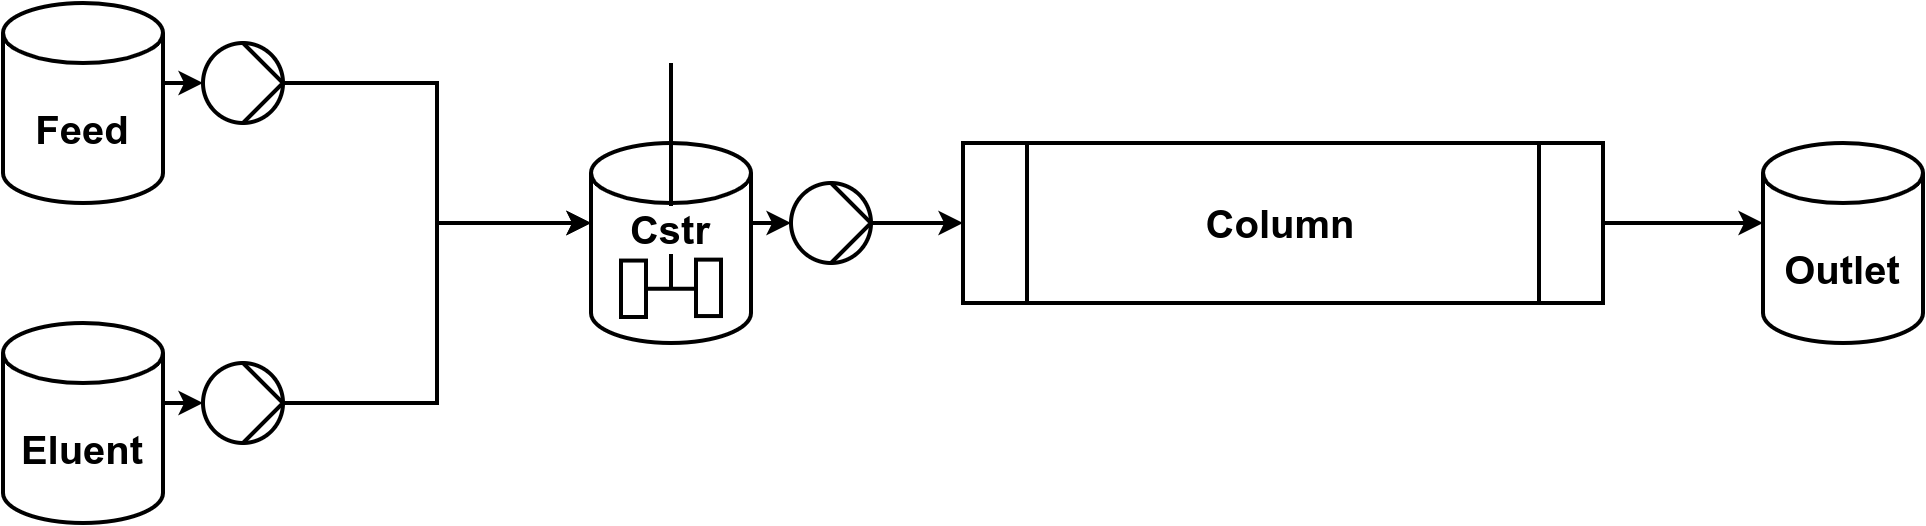

For the column, assume the following parameters which are usually provided by the manufacturer (or can be measured):
- length: $0.1~m$
- diameter: $0.01~m$
- bed porosity: $0.37$
- particle radius: $4.5 \cdot 10^{-5}~m$
- particle porosity: $0.33$
- axial dispersion: $2.0 \cdot 10^{-7}~m^2 \cdot s^{-1}$

For the Langmuir isotherm, use the following parameters:
- adsorption rate: $[0.02, 0.03]~m^3 mol^{-1} s^{-1}$
- desorption rate: $[1, 1]~s^{-1}$
- binding capacity: $[100, 100]~mM$

For the tank, assume a volume of $1 mL$.

Moreover, consider a flow rate of $1~mL/min$, a feed concentration of $10~mM$, and a feed duration of $60~s$.

In [1]:
Q = 1e-6/60

from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import Langmuir
from CADETProcess.processModel import (
    Inlet, Cstr, LumpedRateModelWithPores, Outlet
)
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Process

# Component System
component_system = ComponentSystem(['A', 'B'])

# Binding Model
binding_model = Langmuir(component_system, name='langmuir')
binding_model.is_kinetic = False
binding_model.adsorption_rate = [0.02, 0.03]
binding_model.desorption_rate = [1, 1]
binding_model.capacity = [100, 100]

# Unit Operations
feed = Inlet(component_system, name='feed')
feed.c = [10, 10]

eluent = Inlet(component_system, name='eluent')
eluent.c = [0, 0]

# Mixer
valve = Cstr(component_system, 'valve')
valve.V = 1e-6
valve.flow_rate = Q

# Column
column = LumpedRateModelWithPores(component_system, 'column')
column.binding_model = binding_model
column.length = 0.1
column.diameter = 0.01
column.bed_porosity = 0.37
column.particle_radius = 4.5e-5
column.particle_porosity = 0.33
column.axial_dispersion = 2.0e-7
column.film_diffusion = [1e-4, 1e-4]

outlet = Outlet(component_system, name='outlet')

# Flow Sheet
flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(feed)
flow_sheet.add_unit(eluent)
flow_sheet.add_unit(valve)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(feed, valve)
flow_sheet.add_connection(eluent, valve)
flow_sheet.add_connection(valve, column)
flow_sheet.add_connection(column, outlet)

# Process
process = Process(flow_sheet, 'batch elution')

## Create Events and Durations
process.add_event('feed_on', 'flow_sheet.feed.flow_rate', Q, 0)
process.add_event('feed_off', 'flow_sheet.feed.flow_rate', 0.0, 60)

process.add_event('eluent_off', 'flow_sheet.eluent.flow_rate', 0.0, 0)
process.add_event('eluent_on', 'flow_sheet.eluent.flow_rate', Q, 60)

## Set Process Times
process.cycle_time = 1200

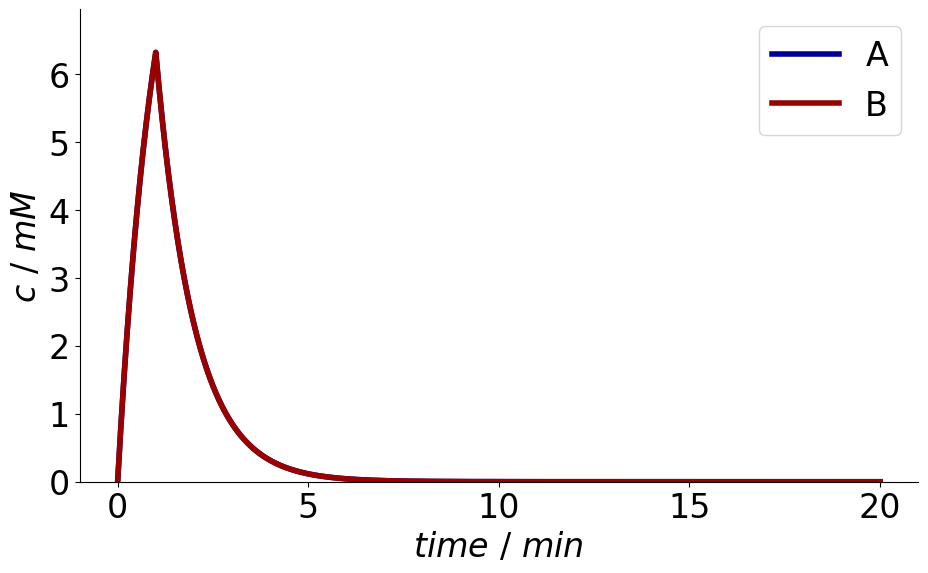

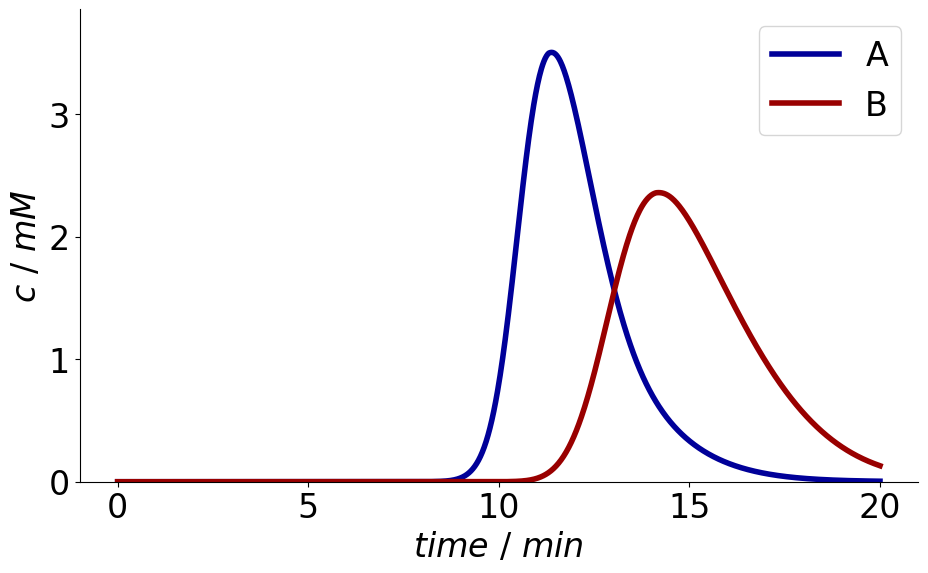

In [2]:
from CADETProcess.simulator import Cadet
process_simulator = Cadet()

simulation_results = process_simulator.simulate(process)
_ = simulation_results.solution.column.inlet.plot()
_ = simulation_results.solution.column.outlet.plot()

## Simulated Moving Bed (Cyclic Systems)

For many applications, the use of multiple columns can improve process performance when compared with conventional batch elution processes.
Next to the well known simulated moving bed (SMB) many other operating modes exist which extend the use of multiple columns, e.g. Varicol, or PowerFeed processes and gradient operations.


In all of the aforementioned processes, multiple chromatographic columns are mounted to a rotating column carousel and a central multiport switching valve distributes in- and outgoing streams to and from the columns. After a given time, the column positions are moved to the next position in the carousel. In this process, the columns pass through different zones which serve different purposes.

For example, in a classical SMB, four zones are present (see Figure below)

- Zone I: Elution of the strongly adsorbing component
- Zone II: Elution of the weakly adsorbing component
- Zone III: Adsorption of the strongly adsorbing component
- Zone IV : Adsorption of the weakly adsorbing component

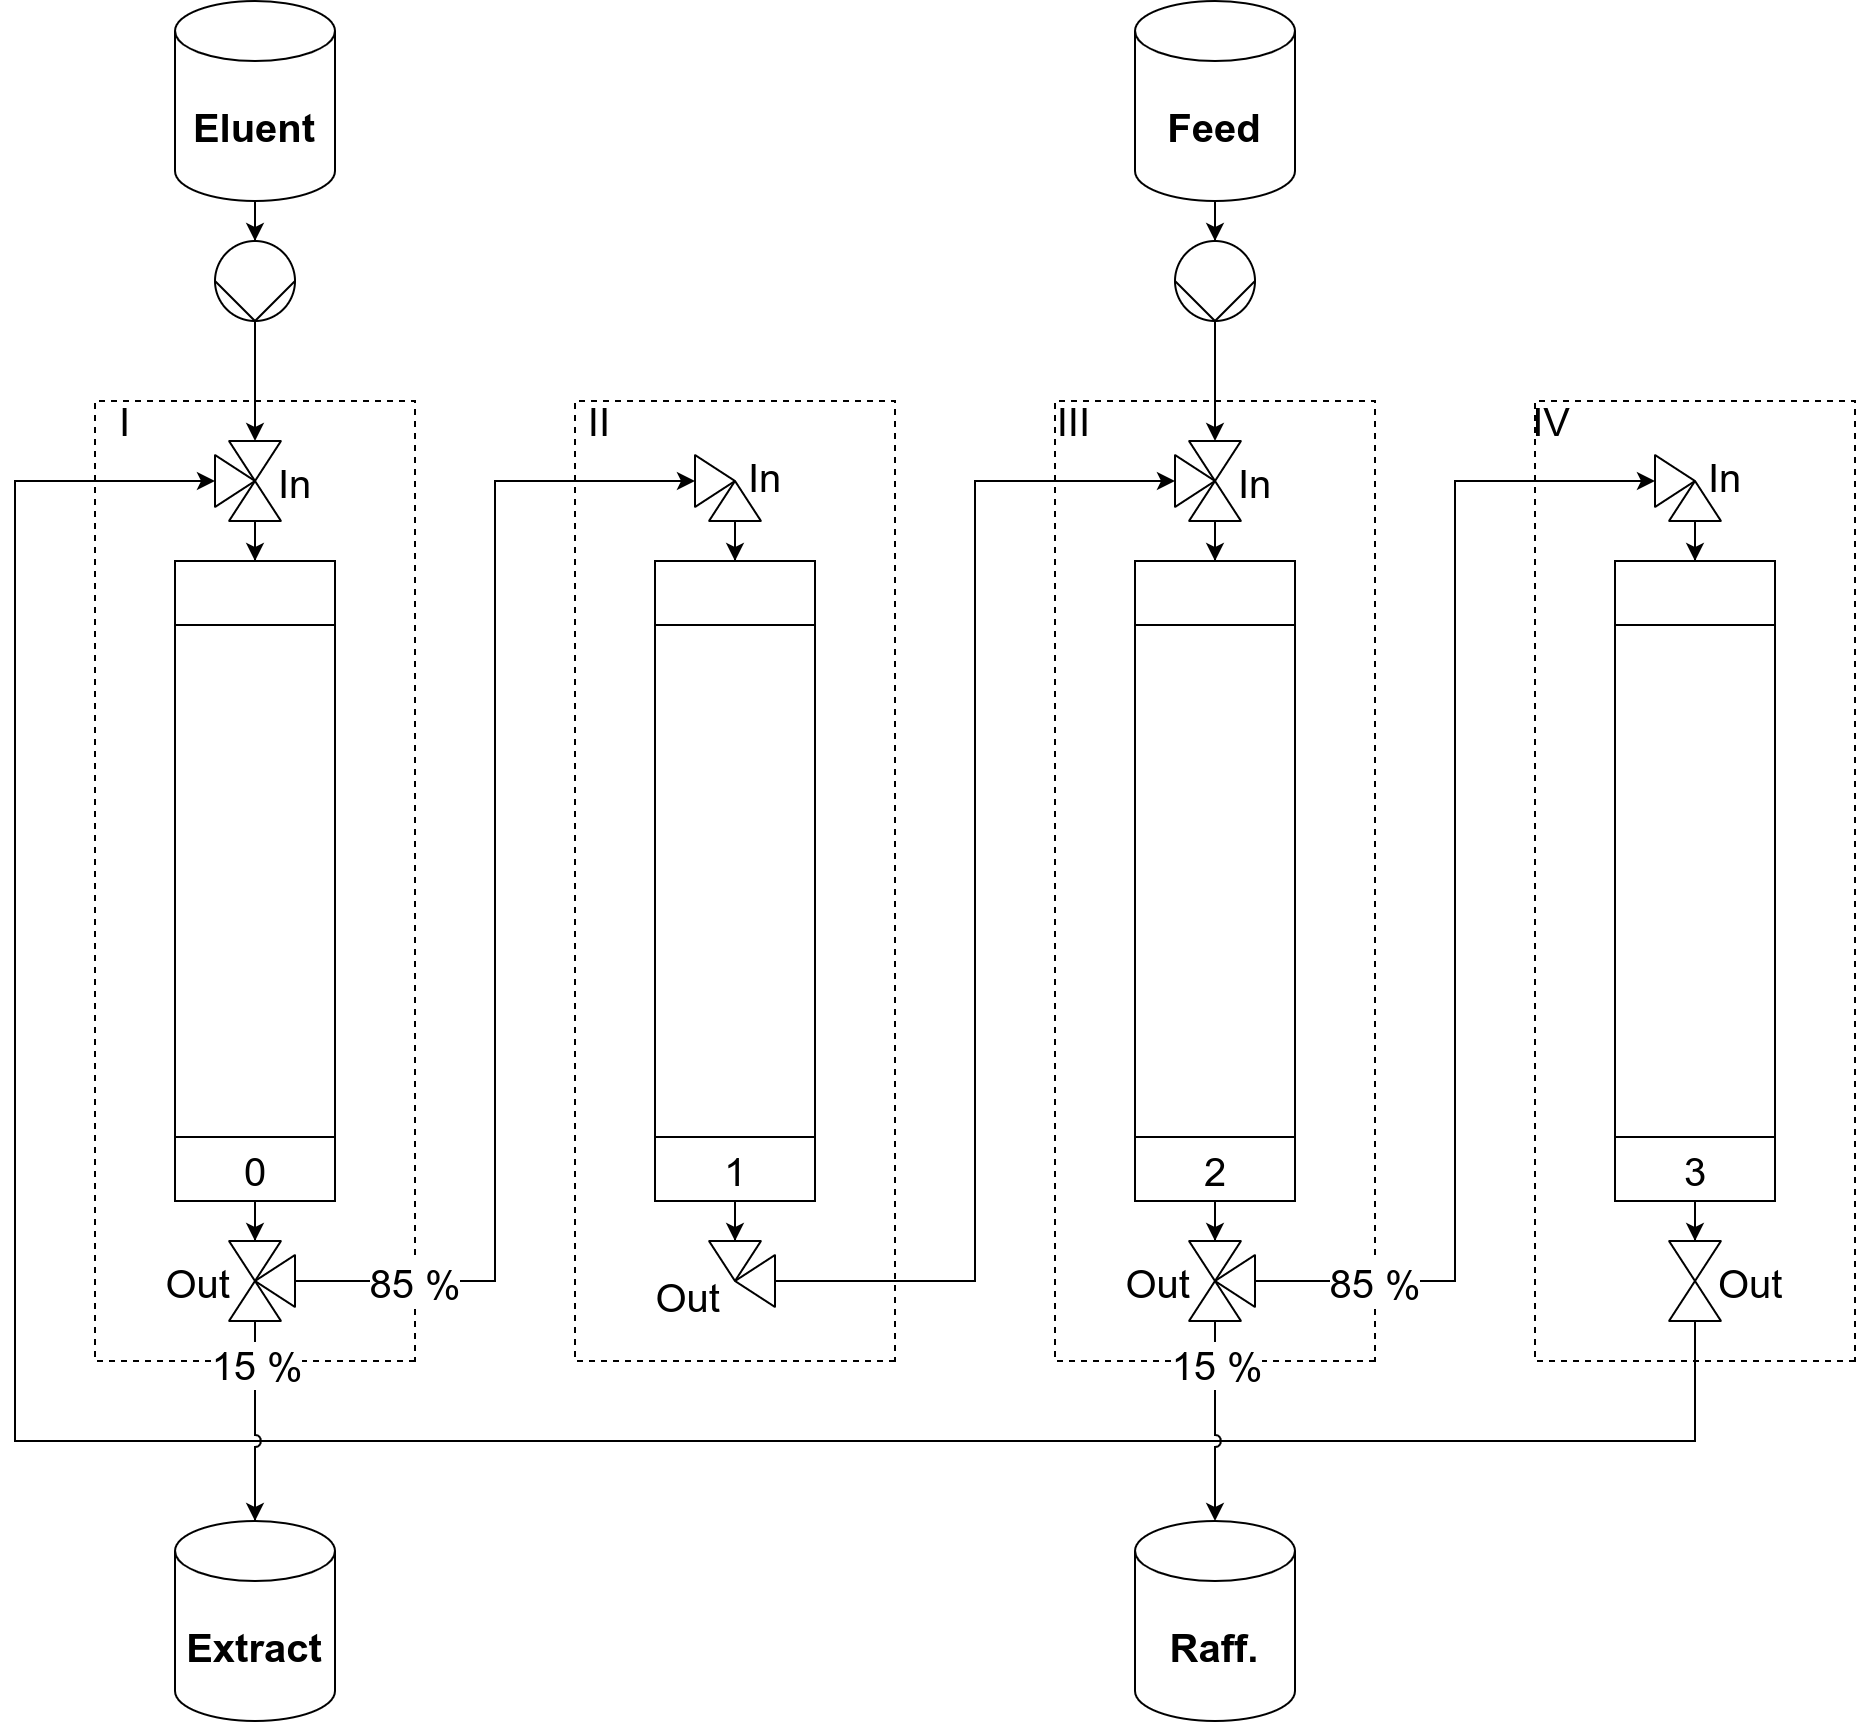

Moreover, four in- and outlets are connected to the zones:
- Feed: Inlet containing the components to be separated
- Eluent: Inlet with elution buffer
- Extract: Outlet containing the strongly adsorbing component
- Raffinate: Outlet containing the weakly adsorbing component

To facilitate the configuration of complex SMB, carousel, or other multi column systems systems, a CarouselBuilder was implemented in CADET-Process.
It allows a straight-forward configuration of the zones and returns a fully configured Process object including all internal connections, as well as switching events.

Before configuring the zones, the binding and column models are configured.
The column is later used as a template for all columns in the system.

In [3]:
from CADETProcess.processModel import ComponentSystem
component_system = ComponentSystem(2)

# Binding Model
from CADETProcess.processModel import Linear
binding_model = Linear(component_system)
binding_model.adsorption_rate = [6, 8]
binding_model.desorption_rate = [1, 1]

from CADETProcess.processModel import LumpedRateModelWithoutPores
column = LumpedRateModelWithoutPores(component_system, name='master_column')
column.length = 0.6
column.diameter = 0.024
column.axial_dispersion = 4.7e-7
column.total_porosity = 0.7

column.binding_model = binding_model

Now, the inlets and outlets of the system are configured:

In [4]:
from CADETProcess.processModel import Inlet, Outlet
feed = Inlet(component_system, name='feed')
feed.c = [10, 10]
feed.flow_rate = 2e-7
eluent = Inlet(component_system, name='eluent')
eluent.c = [0, 0]
eluent.flow_rate = 6e-7

raffinate = Outlet(component_system, name='raffinate')
extract = Outlet(component_system, name='extract')

To allow more complicated systems, CADET-Process provides two options for configuring zones, a SerialZone and a ParallelZone.
For both, the number of columns in the zone needs to be specified.
Since here all the zones only consist of one column, either can be used.

In [5]:
from CADETProcess.modelBuilder import SerialZone, ParallelZone

zone_I = SerialZone(component_system, 'zone_I', 1)
zone_II = SerialZone(component_system, 'zone_II', 1)
zone_III = SerialZone(component_system, 'zone_III', 1)
zone_IV = SerialZone(component_system, 'zone_IV', 1)

The CarouselBuilder can now be used like a regular FlowSheet where the zones are conceptually used like other UnitOperations.
After initializing the CarouselBuilder, the column template is assigned and all units and zones are added.

In [6]:
from CADETProcess.modelBuilder import CarouselBuilder
        
builder = CarouselBuilder(component_system, 'smb')
builder.column = column
builder.add_unit(feed)
builder.add_unit(eluent)

builder.add_unit(raffinate)
builder.add_unit(extract)

builder.add_unit(zone_I)
builder.add_unit(zone_II)
builder.add_unit(zone_III)
builder.add_unit(zone_IV)

Now, the connections are added to the builder.
To define split streams, the output_state is used which sets the ratio between outgoing streams of a unit operation in the flow sheet.

In [7]:
builder.add_connection(eluent, zone_I)

builder.add_connection(zone_I, extract)
builder.add_connection(zone_I, zone_II)
w_e = 0.15
builder.set_output_state(zone_I, [w_e, 1-w_e])

builder.add_connection(zone_II, zone_III)

builder.add_connection(feed, zone_III)

builder.add_connection(zone_III, raffinate)
builder.add_connection(zone_III, zone_IV)
w_r = 0.15
builder.set_output_state(zone_III, [w_r, 1-w_r])

builder.add_connection(zone_IV, zone_I)

Now, the switch time is assigned to the builder which determines after how much time a column is switched to the next position.
By calling the build_process() method, a regular Process object is constructed which can be simulated just as usual using CADET.
It contains the assembled flow sheet with all columns, as well as the events required for simulation.

In [8]:
builder.switch_time = 300
process = builder.build_process()

Since multi column systems often exhibit a transient startup behavior, it might be useful to simulate multiple cycles until cyclic stationarity is reached (see Cyclic Stationarity).
Because this simulation is computationally expensive, only a few simulations are run here.
Please run this simulation locally to see the full results.

In [9]:
from CADETProcess.simulator import Cadet

process_simulator = Cadet()
# process_simulator.evaluate_stationarity = True
process_simulator.n_cycles = 3

simulation_results = process_simulator.simulate(process)

The results can now be plotted.
For example, this is how the concentration profiles of the raffinate and extract outlets are plotted:

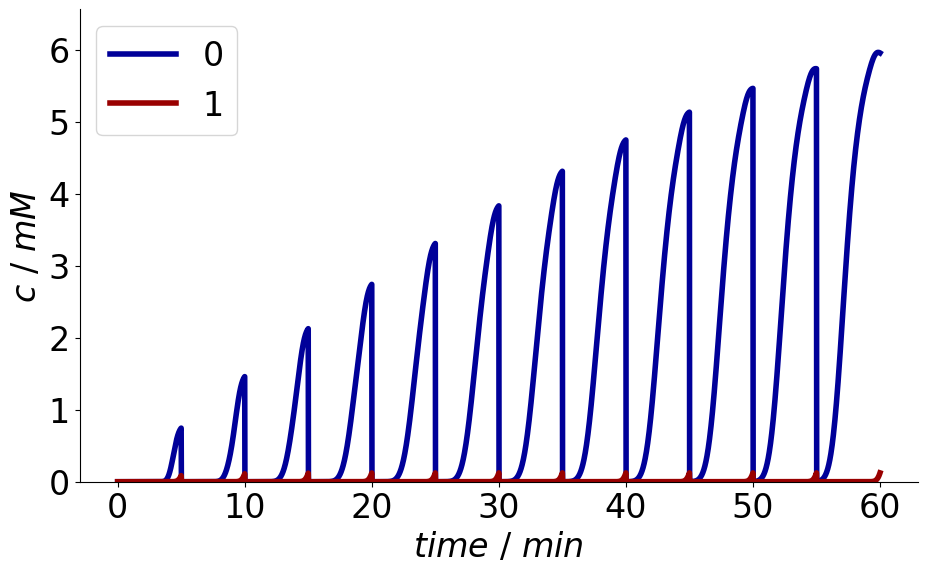

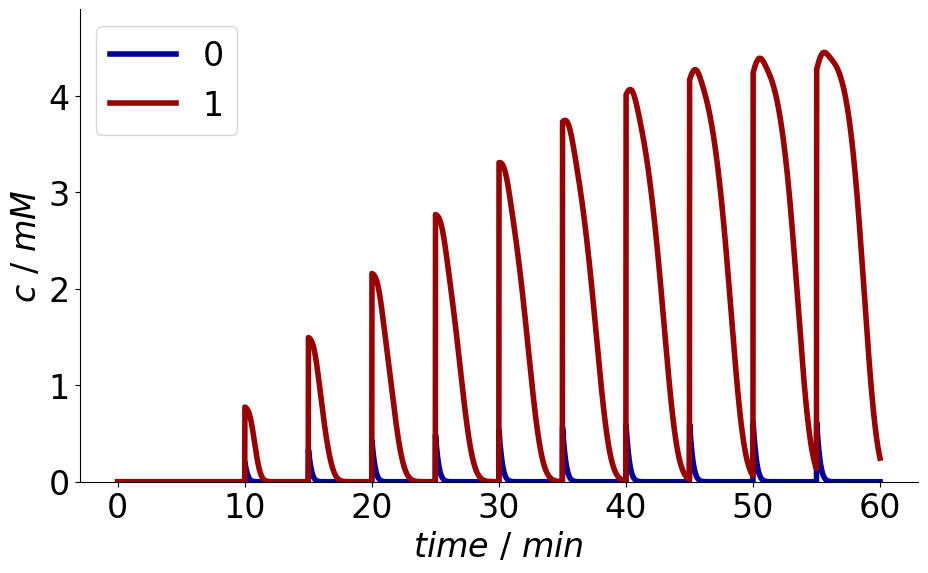

In [10]:
_ = simulation_results.solution.raffinate.inlet.plot()
_ = simulation_results.solution.extract.inlet.plot()